In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from utils import display_matrix
from debug import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
architecture = [784, 500, 10]

x,y = next(iter(train_loader))
x = x.view(x.size(0),-1).to(device).T
y_one_hot = F.one_hot(y, 10).to(device).T

beta = 1
lambda_ = 0.99995
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([0.3, 0.15]), 'fb': np.array([0.15, 0.1])}

neural_lr_start = 0.1
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 20
hopfield_g = 0.05

use_random_sign_beta = False
use_three_phase = True
n_epochs = 20

model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation)

In [5]:
# def append_ones_row_vector_to_tensor(inp_vector):
#     return torch.cat((inp_vector, torch.ones(1, inp_vector.shape[1]).to(inp_vector.device)), 0)

In [6]:
# x, y = next(iter(train_loader))
# x, y = x.to(device), y.to(device)
# x = x.view(x.size(0),-1).T
# y_one_hot = F.one_hot(y, 10).to(device).T
# print(model.B[0]['weight'][:-1].shape)
# neurons = model.init_neurons(x.size(1), device = model.device)

# torch.cat((neurons[0], torch.ones(1, neurons[0].shape[1]).to(device)), 0).shape
# append_ones_row_vector_to_tensor(neurons[0]).shape

In [7]:
_ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
                                          neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                          neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.0897


In [8]:
trn_acc_list = []
tst_acc_list = []

for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.99)**epoch_, 'fb' : lr_start['fb'] * (0.99)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [01:24, 35.54it/s]
4it [00:00, 32.28it/s]

Epoch : 1, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098


86it [00:02, 33.58it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/kuacc/users/bbozkurt15/.conda/envs/bbozkurt15/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_192472/1029133116.py", line 16, in <module>
    neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g,
  File "../../src/debug.py", line 265, in batch_step_hopfield
    neurons = self.run_neural_dynamics_hopfield(x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule,
  File "../../src/debug.py", line 227, in run_neural_dynamics_hopfield
    gradient_neurons = - hopfield_g * neurons_intermediate[jj] + one_over_epsilon * (basal_voltage - neurons_intermediate[jj]) + one_over_epsilon * (apical_voltage - neurons_intermediate[jj])
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/kuacc/users/bbozkurt15/.conda/envs/bbozkurt15/lib/pytho

TypeError: object of type 'NoneType' has no len()

In [ ]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [ ]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [ ]:
plt.figure(figsize = (18, 12))
plt.plot(model.forward_backward_angles, linewidth=2)
plt.xlabel("Number of Debug Points", fontsize=45)
plt.ylabel("Angle (Degree)", fontsize=45)
plt.title("Angles of Forward and Backward Weights", fontsize=45)
plt.grid()
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)
plt.show()

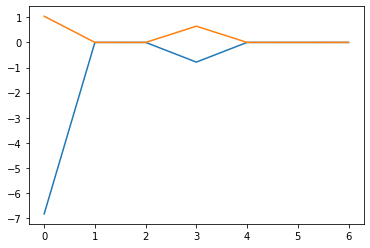

In [9]:
plt.plot(np.array(model.layerwise_forward_corinfo_list_nudged) - np.array(model.layerwise_forward_corinfo_list_free))
# plt.show()

plt.plot(np.array(model.layerwise_backward_corinfo_list_nudged) - np.array(model.layerwise_backward_corinfo_list_free))
# plt.show()



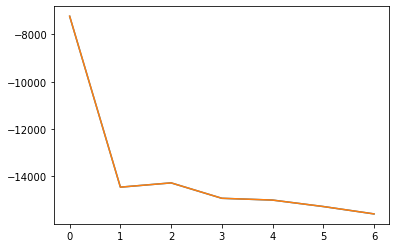

In [10]:
plt.plot(model.layerwise_backward_corinfo_list_free)
# plt.show()

plt.plot(model.layerwise_backward_corinfo_list_nudged)
plt.show()



In [11]:
# model.layerwise_backward_corinfo_list_free, model.layerwise_backward_corinfo_list_nudged

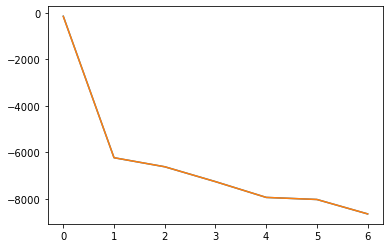

In [12]:
plt.plot(model.layerwise_forward_corinfo_list_free)
# plt.show()

plt.plot(model.layerwise_forward_corinfo_list_nudged)
plt.show()



In [ ]:
plt.plot(np.array(model.layerwise_forward_corinfo_list_free) / np.array(model.layerwise_backward_corinfo_list_free))

In [ ]:
model.layerwise_forward_corinfo_list_free

In [ ]:
model.layerwise_forward_corinfo_list_nudged

In [ ]:
plt.plot(np.array(model.layerwise_forward_corinfo_list_nudged) - np.array(model.layerwise_forward_corinfo_list_free))
# plt.show()

plt.plot(np.array(model.layerwise_backward_corinfo_list_nudged) - np.array(model.layerwise_backward_corinfo_list_free))
# plt.show()



In [ ]:
x,y = next(iter(train_loader))
x, y = x.to(device), y.to(device)
x = x.view(x.size(0),-1).T
y_one_hot = F.one_hot(y, 10).to(device).T

neurons = model.init_neurons(x.size(1), device = model.device)

neurons = model.run_neural_dynamics_hopfield(x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free, 1)

layers = [x] + neurons
Wff = model.Wff
Wfb = model.Wfb
B = model.B
Rfree = model.Rfree
Rnudged = model.Rnudged
print(len(Wff), len(Wfb), len(B), len(Rfree), len(Rnudged))

In [ ]:
torch.norm(neurons[0] - (Wff[0]['weight'] @ x + Wff[0]['bias']))

In [ ]:
norm_check = 0
bs = neurons[0].shape[1]
for ii in range(bs):
    norm_check +=(lambda_ ** (bs - ii + 1)) * torch.norm((neurons[0] - (Wff[0]['weight'] @ x + Wff[0]['bias']))[:,ii])
    
norm_check

In [ ]:
torch.norm(neurons[1] - (Wff[1]['weight'] @ neurons[0] + Wff[1]['bias']))

In [ ]:
norm_check = 0
bs = neurons[0].shape[1]
for ii in range(bs):
    norm_check +=(lambda_ ** (bs - ii + 1)) * torch.norm((neurons[1] - (Wff[1]['weight'] @ neurons[0] + Wff[1]['bias']))[:,ii])
    
norm_check

In [ ]:
58.9840 / 13.4070

In [ ]:
233.0565 / 53.0576

In [ ]:
np.sqrt(20)

In [ ]:
np.log(epsilon), torch.log(torch.Tensor([epsilon]).to(device)) 

In [ ]:
(neurons[0] - (Wff[0]['weight'] @ x + Wff[0]['bias'])).shape

In [ ]:
norm_check = 0
bs = neurons[0].shape[1]
for ii in range(bs):
    norm_check +=(lambda_ ** (bs - ii + 1)) * torch.norm((neurons[0] - (Wff[0]['weight'] @ x + Wff[0]['bias']))[:,4])
    
norm_check

In [ ]:
lambda_

In [ ]:
torch.linalg.matrix_rank(R[0]['weight'])

In [ ]:
(torch.eye(*R[0]['weight'].shape).to(device))

In [ ]:
torch.logdet(R[0]['weight'] + epsilon * torch.eye(*R[0]['weight'].shape).to(device))

In [ ]:
torch.logdet(R[0]['weight'].type(torch.float64) + epsilon * torch.eye(*R[0]['weight'].shape).to(device))

In [ ]:
torch.float64

In [ ]:
torch2numpy(epsilon * torch.eye(*R[0]['weight'].shape).to(device)).shape

In [ ]:
np.linalg.det(torch2numpy(R[0]['weight']))

In [ ]:
np.linalg.det(torch2numpy(R[0]['weight'] + epsilon * torch.eye(*R[0]['weight'].shape).to(device))) == 0

In [ ]:
torch.linalg.matrix_rank(B[0]['weight'])

In [ ]:
np.linalg.det(torch2numpy(B[0]['weight']))

In [ ]:
torch.logdet(B[0]['weight'])

In [ ]:
forward_info_list = []
for jj in range(len(model.architecture) - 2):
    forward_info_jj = (torch.logdet(R[jj + 1]['weight'] + epsilon * torch.eye(*R[jj + 1]['weight'].shape).to(device)) - one_over_epsilon * torch.norm(layers[jj + 2] - Wff[jj + 1]['weight'] @ layers[jj + 1] - Wff[jj + 1]['bias']) ** 2).item()
    forward_info_list.append(forward_info_jj)
    
backward_info_list = []
for jj in range(len(model.architecture) - 2):
    backward_info_jj = (torch.logdet(R[jj]['weight'] + epsilon * torch.eye(*R[jj]['weight'].shape).to(device)) - one_over_epsilon * torch.norm(model.append_ones_row_vector_to_tensor(layers[jj + 1]) - Wfb[jj + 1]['weight'] @ layers[jj + 2]) ** 2).item()
    backward_info_list.append(backward_info_jj)

In [ ]:
forward_info_list, backward_info_list

In [ ]:
jj = -1
torch.logdet(torch.inverse(B[jj + 1]['weight']) + epsilon * torch.eye(*B[jj + 1]['weight'].shape).to(device))

In [ ]:
jj = -1
torch.logdet(torch.inverse(B[jj + 1]['weight'][:-1,:-1]) + epsilon * torch.eye(*B[jj + 1]['weight'][:-1,:-1].shape).to(device))

In [ ]:
jj = -1
torch.logdet(torch.inverse((B[jj + 1]['weight']) + epsilon * torch.eye(*B[jj + 1]['weight'].shape).to(device))[:-1,:-1])

In [ ]:
torch.logdet(torch.inverse(B[0]['weight']) + epsilon * torch.eye(*B[0]['weight'].shape).to(device)) - one_over_epsilon * torch.norm(model.append_ones_row_vector_to_tensor(layers[1]) - Wfb[1]['weight'] @ layers[2]) ** 2

In [ ]:
(Wff[1]['weight'] @ layers[1] -  Wff[1]['bias']).shape

In [ ]:
layers[2].shape

In [ ]:
torch.logdet(torch.inverse(B[1]['weight']) + epsilon * torch.eye(*B[1]['weight'].shape).to(device)) - one_over_epsilon * torch.norm(layers[2] - Wff[1]['weight'] @ layers[1] - Wff[1]['bias']) ** 2

In [ ]:
display_matrix(model.B[0]['weight'][:10,:10])

In [ ]:
display_matrix(torch.linalg.inv(model.R[0]['weight'])[:10,:10])

In [ ]:
# from torch_utils import *

In [ ]:
# def angle_between_two_matrices(A, B):
#     """Computes the angle between two matrices A and B.

#     Args:
#         A (torch.Tensor): Pytorch tensor of size m times n
#         B (torch.Tensor): Pytorch tensor of size m times n

#     Returns:
#         angle: angle between the matrices A and B. The formula is given by the following:
#                (180/pi) * acos[ Tr(A @ B.T) / sqrt(Tr(A @ A.T) * Tr(B @ B.T))] 
#     """

#     angle = (180 / torch.pi) * torch.acos(torch.trace(A @ B.T) / torch.sqrt(torch.trace(A @ A.T) * torch.trace(B @ B.T)))
#     return angle

In [ ]:
plt.plot(model.forward_backward_angles)

In [ ]:
angle_between_two_matrices(model.Wff[1]['weight'], model.Wfb[1]['weight'].T).item()

In [ ]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [ ]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])